In [268]:
import scanpy as sc
import numpy as np

# Load & Explore the dataset

The **pbmc3k dataset** is a widely used single-cell RNA-seq dataset that contains around 3,000 peripheral blood mononuclear cells (PBMCs) from a healthy donor. This dataset was generated by 10X Genomics and is commonly used as a benchmark in single-cell analysis pipelines. PBMCs are a diverse collection of immune cells including T cells, B cells, natural killer (NK) cells, and monocytes.

## Dataset Construction

The pbmc3k dataset is provided in the form of an **AnnData** object, a popular data structure in the Scanpy ecosystem designed specifically for single-cell data. Key components of the AnnData object include:

- **adata.X**: The main data matrix where each row represents a cell and each column represents a gene.
- **adata.obs**: A pandas DataFrame that contains metadata for each cell (e.g., total counts, number of detected genes).
- **adata.var**: A pandas DataFrame that holds metadata for each gene (e.g., gene names, whether a gene is mitochondrial).

Below, we load and explore the pbmc3k dataset.


In [269]:
# Load the pbmc3k dataset
adata = sc.datasets.pbmc3k()

# print the basic information of the dataset
print("Basic information:")
print(adata)

# View the first few rows of the cell metadata (obs)
print("\nCell Metadata (obs): ")
print(adata.obs.head())

# View the first few rows of the gene metadata (var)
print("\nGene Metadata (var):")
print(adata.var.head())

# Print the shape of the main data matrix (cells x genes)
print("\nData Matrix Shape:")
print(adata.X.shape)

Basic information:
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

Cell Metadata (obs): 
Empty DataFrame
Columns: []
Index: [AAACATACAACCAC-1, AAACATTGAGCTAC-1, AAACATTGATCAGC-1, AAACCGTGCTTCCG-1, AAACCGTGTATGCG-1]

Gene Metadata (var):
                     gene_ids
index                        
MIR1302-10    ENSG00000243485
FAM138A       ENSG00000237613
OR4F5         ENSG00000186092
RP11-34P13.7  ENSG00000238009
RP11-34P13.8  ENSG00000239945

Data Matrix Shape:
(2700, 32738)


## pbmc3k Dataset Description

Here are its key characteristics:

- **Number of Cells (`n_obs`):** 2,700  
- **Number of Genes (`n_vars`):** 32,738  
- **Data Structure:** Stored in an AnnData object, which is a common format for single-cell data in Python.

AnnData Structure:

1. **`adata.obs` (Cell Metadata):**  
   - **Index:** Unique cell barcodes (e.g., `AAACATACAACCAC-1`).  
   - **Columns:** Empty in this particular dataset, as no additional cell-level annotations are provided by default.

2. **`adata.var` (Gene Metadata):**  
   - **Index:** Gene symbols or IDs (e.g., `MIR1302-10`).  
   - **Columns:** Typically contains at least one column, here named `"gene_ids"`, which stores the corresponding Ensembl gene IDs.

3. **`adata.X` (Main Data Matrix):**  
   - A matrix of size `n_obs x n_vars` (2,700 × 32,738 in this case).  
   - Each row corresponds to a cell, and each column corresponds to a gene.  
   - The values are gene expression counts (or sometimes transformed counts).
      - **Gene Expression Counts**: Raw counts (also called UMI counts in many single-cell protocols) represent the number of times a given transcript (gene) was detected in each cell.
      - **Transformed Counts**: Transformed counts are derived from raw counts through operations such as normalization and log-transformation. 

# Simulate Batch Effects
We simulate batch effects by dividing the dataset into two artificial batches.

### Why do we simulate Batch Effects?
- **Testing Batch Correction Methods:**
The pbmc3k dataset originally comes from a single batch, meaning it lacks inherent batch effects. By artificially dividing the data, we create a scenario where batch effects are present. This allows us to test and validate batch integration methods (like Scanorama) in a controlled setting.

- **Mimicking Real-World Data:**
Many real-world single-cell experiments involve multiple batches. Simulating batches helps us understand how our analysis pipeline would perform on data where batch-to-batch variability is a concern.

### Why Only Two Batches? 
   - **Common Scenario:** Many single-cell experiments involve two batches, especially when comparing different experimental conditions or replicates.
   - **Simplicity in Demonstration:** Using two batches keeps the example straightforward while still demonstrating the need for batch integration. More complex scenarios can be explored by creating additional artificial batches if needed.

In [270]:
# The number of cells
n_cells = adata.n_obs

# Split into two equal halves based on indices
adata.obs['batch'] = np.where(np.arange(n_cells) < n_cells / 2, 'batch1', 'batch2')
print(adata.obs)

                   batch
index                   
AAACATACAACCAC-1  batch1
AAACATTGAGCTAC-1  batch1
AAACATTGATCAGC-1  batch1
AAACCGTGCTTCCG-1  batch1
AAACCGTGTATGCG-1  batch1
...                  ...
TTTCGAACTCTCAT-1  batch2
TTTCTACTGAGGCA-1  batch2
TTTCTACTTCCTCG-1  batch2
TTTGCATGAGAGGC-1  batch2
TTTGCATGCCTCAC-1  batch2

[2700 rows x 1 columns]


In this example, we are using a simple, straightforward criterion to split the dataset into two artificial batches:
   - `np.arange(n_cells)` generates an array of indices from 0 to `n_cells - 1`.
   - The condition `< n_cells / 2` splits this array into two equal halves.
   - Cells with indices in the first half are labeled as `'batch1'`, and the rest are labeled as `'batch2'`.

### Why This Specific Criterion?
   - **Simplicity:** Dividing the dataset by the index is an easy and reproducible way to split the data evenly.
   - **Balance:** By splitting the cells equally, we ensure that each batch has a similar number of cells, which is useful for comparing the performance of batch correction methods.
   - **Controlled Simulation:** Since the original pbmc3k dataset does not have natural batch effects, this method allows us to simulate a batch effect scenario in a controlled manner.


# Quality Control 

In this step, we compute QC metrics including:
- Total counts per cell (The sum of all gene counts)
- Number of genes detected per cell
- Percentage of mitochondrial gene counts

We visualize these metrics using plots and filter out considering MAD (median absolute deviations).


In [271]:
# Mark mitochondrial genes (gene names starting with 'MT-' since the dataset is about human cells)
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Compute QC metrics for each cell
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

print(adata.obs.head())

                   batch  n_genes_by_counts  log1p_n_genes_by_counts  \
index                                                                  
AAACATACAACCAC-1  batch1                781                 6.661855   
AAACATTGAGCTAC-1  batch1               1352                 7.210080   
AAACATTGATCAGC-1  batch1               1131                 7.031741   
AAACCGTGCTTCCG-1  batch1                960                 6.867974   
AAACCGTGTATGCG-1  batch1                522                 6.259581   

                  total_counts  log1p_total_counts  \
index                                                
AAACATACAACCAC-1        2421.0            7.792349   
AAACATTGAGCTAC-1        4903.0            8.497807   
AAACATTGATCAGC-1        3149.0            8.055158   
AAACCGTGCTTCCG-1        2639.0            7.878534   
AAACCGTGTATGCG-1         981.0            6.889591   

                  pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
index                                  

Several new columns are appended to `adata.obs`. Here’s what each column represents:

`n_genes_by_counts`: The number of genes (features) detected in each cell with at least one count.

`log1p_n_genes_by_counts`: The natural logarithm of (1 + n_genes_by_counts).

`total_counts`: The total number of counts (sum of all gene counts) for each cell.

`log1p_total_counts`: The natural logarithm of (1 + total_counts).

`pct_counts_mt`: The proportion of total counts for a cell which are mitochondrial.

`pct_counts_in_top_50_genes`, `pct_counts_in_top_100_genes`, `pct_counts_in_top_200_genes`, `pct_counts_in_top_500_genes`: The percentage of each cell’s total counts that come from the top 50, 100, 200, or 500 most highly expressed genes. 

### What Does "Expressed" Mean in Single-Cell RNA-seq?

In the context of single-cell RNA-seq, when we say that a gene is "expressed" in a cell, we mean that:

1. **Transcription is Occurring:**  
   The gene is actively being transcribed into messenger RNA (mRNA) in that cell. This mRNA is then captured and sequenced during the experiment.

2. **Detection in Data:**  
   A gene is considered expressed if its mRNA is detected, resulting in a non-zero count (e.g., at least 1 count). If a gene has 0 counts, it means that no mRNA for that gene was detected in that particular cell—either because it wasn’t transcribed or its expression level was below the detection threshold.

3. **Biological and Technical Aspects:**  
   - **Biologically:**  
     Expression indicates that the gene might be functionally active in that cell, potentially playing a role in the cell's structure, function, or response to environmental cues.
   - **Technically:**  
     Due to limitations such as the dropout effect (where lowly expressed genes might not be captured), sometimes a gene might actually be expressed at very low levels but still show 0 counts in the data.


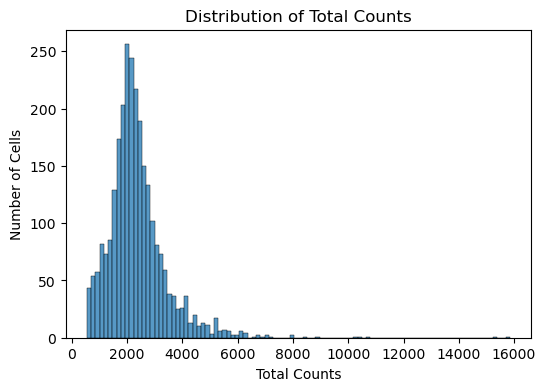

In [272]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram of total counts using seaborn
plt.figure(figsize=(6, 4))
p1 = sns.histplot(data=adata.obs, x='total_counts', bins=100, kde=False)
p1.set_xlabel('Total Counts')
p1.set_ylabel('Number of Cells')
p1.set_title('Distribution of Total Counts')
plt.show()

This histogram shows how many cells (y‐axis) have a given total UMI count (x‐axis). Most cells fall into a lower total count range (peaking around a few hundred to a few thousand UMIs), with fewer cells showing very high total counts, resulting in a right‐skewed distribution typical of single‐cell RNA‐seq data.

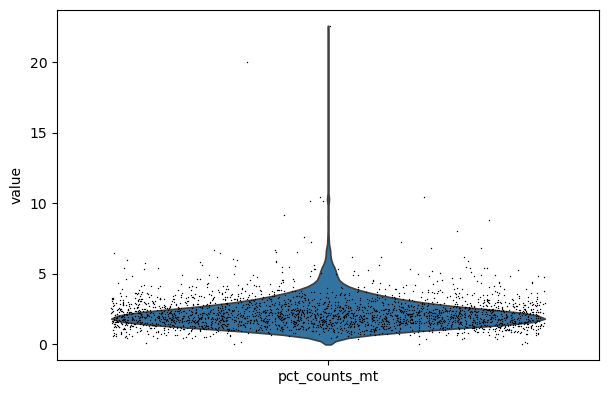

In [273]:
# Violin plot of percentage of mitochondrial counts
sc.pl.violin(
    adata, 
    keys='pct_counts_mt', 
    jitter=0.4
)



This violin plot shows the distribution of percent mitochondrial reads per cell (`pct_counts_mt`). The width of the violin indicates how many cells have a given mitochondrial percentage, and each black dot represents one cell. Most cells cluster at a relatively low mitochondrial percentage (under ~5%), but a small number of cells exhibit much higher mitochondrial content (reaching over 20%), which can indicate stressed or low‐quality cells in single‐cell RNA‐seq experiments.

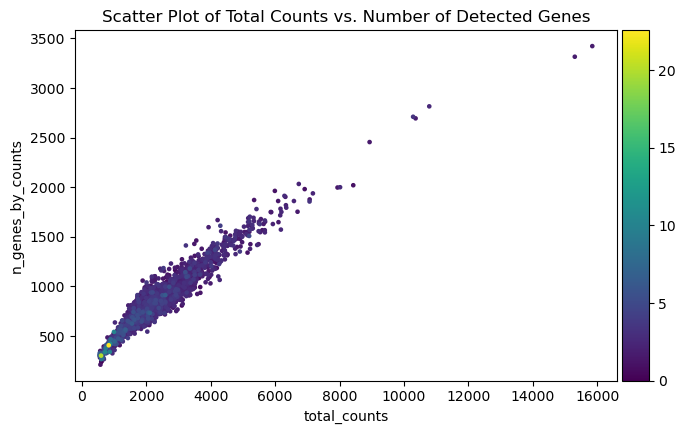

In [274]:
# Scatter plot of total_counts vs. n_genes_by_counts
# colored by pct_counts_mt
sc.pl.scatter(
    adata, 
    x='total_counts', 
    y='n_genes_by_counts', 
    color='pct_counts_mt',
    title='Scatter Plot of Total Counts vs. Number of Detected Genes'
)

This scatter plot compares each cell’s total UMI counts (x-axis) to the number of detected genes (y-axis), with points colored by the percentage of mitochondrial reads (`pct_counts_mt`). Generally, cells with higher total counts also have more detected genes, indicating a positive relationship between sequencing depth and gene detection. The color scale shows the mitochondrial fraction, where lower values (cooler colors) suggest healthier cells, while higher values (warmer colors) can signal stressed or low-quality cells.

# QC Filtering for PBMC 3k using MAD-based Outlier Detection

Below is an outline of a common QC workflow in single-cell RNA-seq analysis:
1. **Define a function** to identify outliers based on Median Absolute Deviation (MAD).
2. **Compute log-transformed metrics** (e.g., total counts, number of genes).
3. **Flag outliers** for these metrics and the mitochondrial percentage.
4. **Filter** the dataset to exclude flagged cells.

The thresholds (i.e., the number of MADs) can be adjusted based on the dataset’s characteristics and biological context.

Total number of cells before filtering: 2700
Number of cells after filtering: 2599


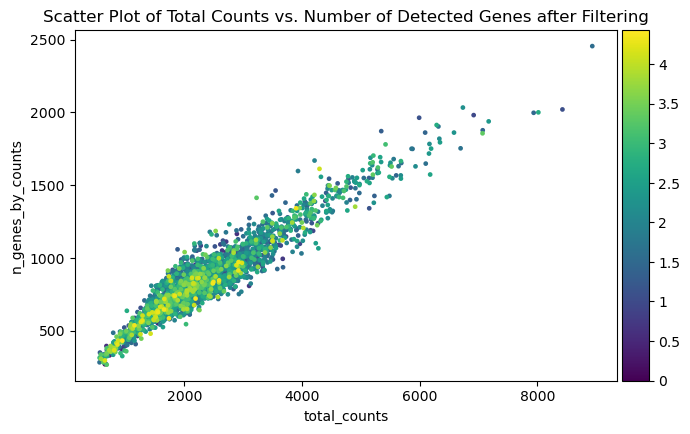

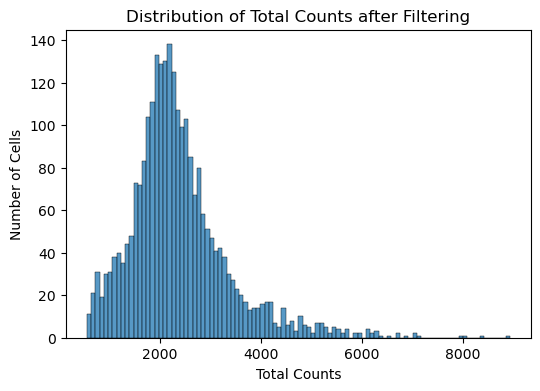

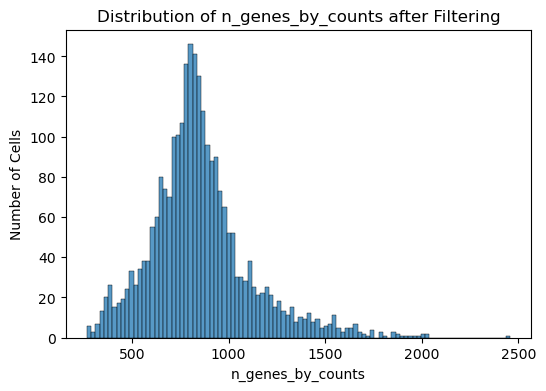

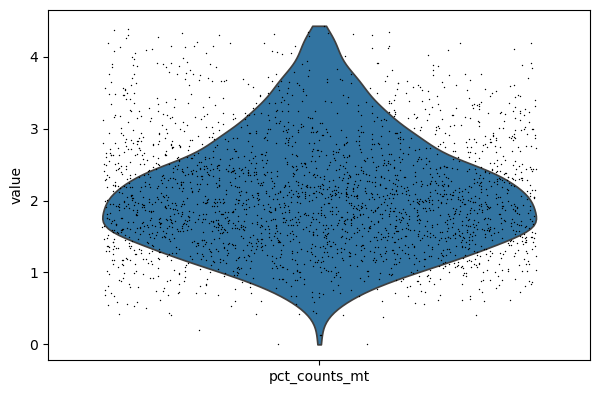

In [275]:
from scipy.stats import median_abs_deviation

# 1. Define a function to detect outliers based on MAD
def is_outlier(adata, metric, n_mads=5):
    """
    Flags cells that are more than `n_mads` median absolute deviations
    away from the median for a given metric in adata.obs.
    """
    M = adata.obs[metric]
    med = np.median(M)
    mad = median_abs_deviation(M, scale='normal')
    
    outlier_mask = (M < med - n_mads * mad) | (M > med + n_mads * mad)
    return outlier_mask

# 2. Create log-transformed metrics for total counts and number of genes
adata.obs["log1p_total_counts"] = np.log1p(adata.obs["total_counts"])
adata.obs["log1p_n_genes_by_counts"] = np.log1p(adata.obs["n_genes_by_counts"])

# 3. Flag outliers for total counts, number of genes, and mitochondrial percentage
adata.obs["outlier_total_counts"] = is_outlier(adata, "log1p_total_counts", n_mads=5)
adata.obs["outlier_n_genes"] = is_outlier(adata, "log1p_n_genes_by_counts", n_mads=5)
adata.obs["outlier_pct_counts_mt"] = is_outlier(adata, "pct_counts_mt", n_mads=3)

# 4. Combine outlier masks and filter the data
combined_outlier_mask = (
    adata.obs["outlier_total_counts"] |
    adata.obs["outlier_n_genes"] |
    adata.obs["outlier_pct_counts_mt"]
)

print(f"Total number of cells before filtering: {adata.n_obs}")

# Filter out the outliers
adata_filtered = adata[~combined_outlier_mask].copy()

print(f"Number of cells after filtering: {adata_filtered.n_obs}")
# Scatter plot of total_counts vs. n_genes_by_counts
# colored by pct_counts_mt
sc.pl.scatter(
    adata_filtered, 
    x='total_counts', 
    y='n_genes_by_counts', 
    color='pct_counts_mt',
    title='Scatter Plot of Total Counts vs. Number of Detected Genes after Filtering' 
)

plt.figure(figsize=(6, 4))
p1 = sns.histplot(data=adata_filtered.obs, x='total_counts', bins=100, kde=False)
p1.set_xlabel('Total Counts')
p1.set_ylabel('Number of Cells')
p1.set_title('Distribution of Total Counts after Filtering')
plt.show()

plt.figure(figsize=(6, 4))
p1 = sns.histplot(data=adata_filtered.obs, x='n_genes_by_counts', bins=100, kde=False)
p1.set_xlabel('n_genes_by_counts')
p1.set_ylabel('Number of Cells')
p1.set_title('Distribution of n_genes_by_counts after Filtering')
plt.show()

# Violin plot of percentage of mitochondrial counts
sc.pl.violin(
    adata_filtered, 
    keys='pct_counts_mt', 
    jitter=0.4
)

**Total Counts and Number of Genes:** The histogram and scatter plot both show a long but modest tail extending to higher counts. We may lower the MAD.

**Mitochondrial Percentage:** The violin plot shows most cells around 1–3%, with very few going beyond ~4–5%. That’s fairly typical for healthy PBMCs, so using 3 MADs is likely already stringent enough.


Total number of cells before filtering: 2700
Number of cells after filtering: 2521


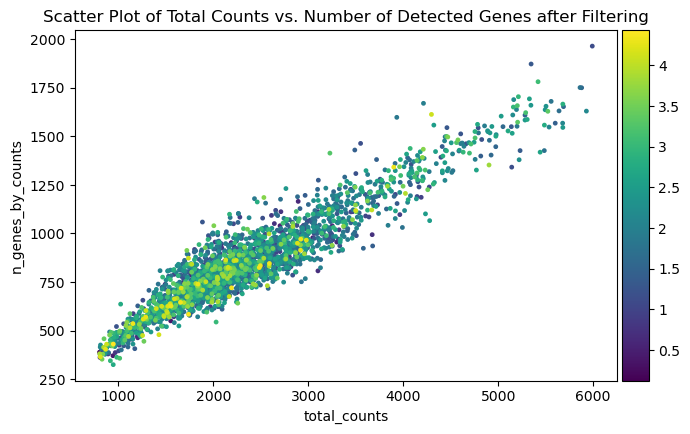

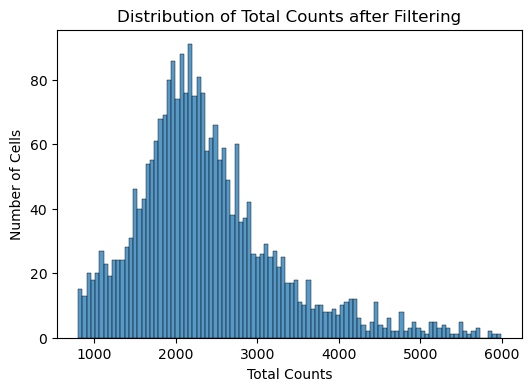

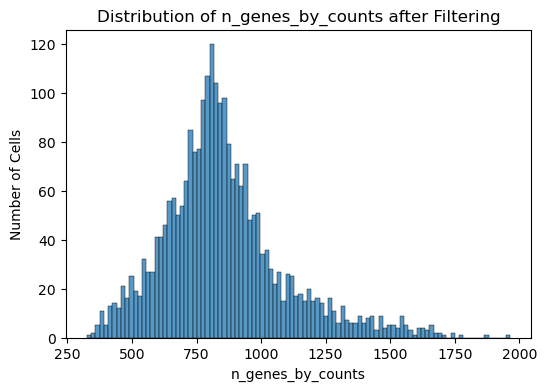

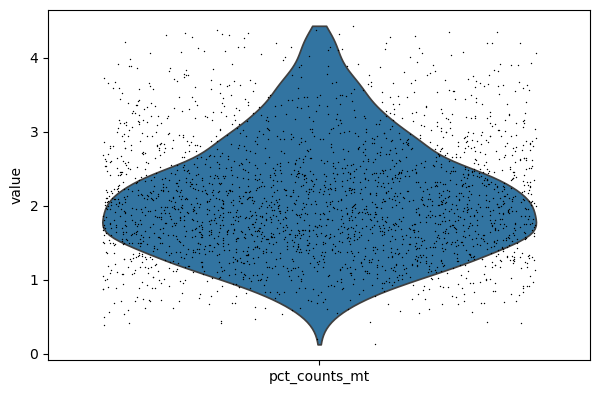

In [276]:
adata.obs["outlier_total_counts"] = is_outlier(adata, "log1p_total_counts", n_mads=3)
adata.obs["outlier_n_genes"] = is_outlier(adata, "log1p_n_genes_by_counts", n_mads=4)
adata.obs["outlier_pct_counts_mt"] = is_outlier(adata, "pct_counts_mt", n_mads=3)

combined_outlier_mask = (
    adata.obs["outlier_total_counts"] |
    adata.obs["outlier_n_genes"] |
    adata.obs["outlier_pct_counts_mt"]
)

print(f"Total number of cells before filtering: {adata.n_obs}")

# Filter out the outliers
adata_filtered = adata[~combined_outlier_mask].copy()

print(f"Number of cells after filtering: {adata_filtered.n_obs}")
# Scatter plot of total_counts vs. n_genes_by_counts
# colored by pct_counts_mt
sc.pl.scatter(
    adata_filtered, 
    x='total_counts', 
    y='n_genes_by_counts', 
    color='pct_counts_mt',
    title='Scatter Plot of Total Counts vs. Number of Detected Genes after Filtering' 
)

plt.figure(figsize=(6, 4))
p1 = sns.histplot(data=adata_filtered.obs, x='total_counts', bins=100, kde=False)
p1.set_xlabel('Total Counts')
p1.set_ylabel('Number of Cells')
p1.set_title('Distribution of Total Counts after Filtering')
plt.show()

plt.figure(figsize=(6, 4))
p1 = sns.histplot(data=adata_filtered.obs, x='n_genes_by_counts', bins=100, kde=False)
p1.set_xlabel('n_genes_by_counts')
p1.set_ylabel('Number of Cells')
p1.set_title('Distribution of n_genes_by_counts after Filtering')
plt.show()

# Violin plot of percentage of mitochondrial counts
sc.pl.violin(
    adata_filtered, 
    keys='pct_counts_mt', 
    jitter=0.4
)

After adjusting the MAD values, removing only about 200 cells (out of 2700) is still not excessive—roughly 7–8% of the dataset. Visually, the new plots show a tighter range of total counts and detected genes.

### Why do we apply a log transformation (using log1p) to total counts and n_genes_by_counts?
because these metrics are often highly skewed and span several orders of magnitude. Log-transforming them helps stabilize the variance and makes the distributions more symmetric, which in turn improves the sensitivity of our outlier detection (e.g., using MAD-based thresholds).



### Why don't we consider metrics such as pct_counts_in_top_50_genes, pct_counts_in_top_100_genes, etc?
They can be informative in some contexts—for instance, to detect whether a small number of genes dominate the transcriptome. However, in many standard QC workflows (especially for datasets like PBMC 3k), the focus is often on total counts, number of genes, and mitochondrial percentage since these directly correlate with cell viability and overall data quality. These additional metrics might be omitted for simplicity or because they provide redundant information when the primary metrics already indicate low-quality cells.

# CLR Normalization

We apply a custom Centered Log-Ratio (CLR) normalization.  
For each cell, we compute:  CLR = log(x + 1) - mean(log(x + 1))  
This centers the log-transformed counts for each cell.

In [277]:
# Assign adata as the filtered one.
adata = adata_filtered

# If the data is in sparse format, convert it to a dense array for CLR computation.
if not isinstance(adata.X, np.ndarray):
    adata.X = adata.X.toarray()

def clr_normalization(X):
    """
    Apply Centered Log-Ratio (CLR) normalization to a count matrix X.
    For each cell (row), compute: CLR = log(x + 1) - mean(log(x + 1))
    """
    X_pseudo = X + 1  # Add pseudocount to avoid log(0)
    log_X = np.log(X_pseudo)
    log_X_centered = log_X - np.mean(log_X, axis=1, keepdims=True)
    return log_X_centered

# Apply CLR normalization and store in a new layer
adata.layers["clr"] = clr_normalization(adata.X)

# Use the CLR normalized data for downstream analysis
adata.X = adata.layers["clr"]

In [278]:
adata

AnnData object with n_obs × n_vars = 2521 × 32738
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier_total_counts', 'outlier_n_genes', 'outlier_pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'clr'

### Why Do We Need Normalization in Single-Cell RNA-seq?

1. **Correcting for Library Size Differences:**  
   Each cell may capture a different total number of transcripts due to variability in sequencing depth or capture efficiency. Normalization adjusts the counts so that differences in library size do not confound downstream analyses.

2. **Mitigating Technical Noise:**  
   Single-cell data is subject to various technical artifacts, such as dropout events (where lowly expressed genes are not detected). Normalization helps reduce the impact of these artifacts and makes cells more comparable.

3. **Ensuring Meaningful Comparisons:**  
   Without normalization, cells with higher total counts would dominate analyses like clustering or dimensionality reduction. Normalizing the data ensures that observed differences are more likely due to biological variation rather than technical biases.

4. **Preparing Data for Downstream Analysis:**  
   Many downstream methods (e.g., PCA, clustering) assume that the input data is on a comparable scale across cells. Normalization brings the data closer to meeting these assumptions.

# Feature Selection: Identifying Highly Variable Genes

Feature selection is a crucial step in single-cell RNA-seq analysis. It helps to focus on the genes that exhibit the most variation across cells, which are more likely to carry important biological signals. 

### How to Perform Feature Selection
We use Scanpy's `sc.pp.highly_variable_genes` function, which offers methods like 'seurat', 'cell_ranger', or 'dispersion' to select the top variable genes. In this example, we use the 'seurat' method to select the top 2,000 highly variable genes.


### Why Choose the Seurat Method?
While `cell_ranger` and `dispersion` are valid options for feature selection, the Seurat method is often preferred for its robust performance in capturing biologically meaningful variability, especially in the pbmc3k dataset. This approach strikes a good balance between sensitivity (capturing important genes) and specificity (excluding noise), which is crucial for downstream analyses such as PCA, clustering, and differential expression.

### Why Select the Top 2,000 Genes?

- **Balance Between Signal and Efficiency:**  
  Choosing the top 2,000 highly variable genes often captures the most informative features while reducing noise and computational load.
- **Empirical Default:**  
  Many studies have found that 2,000 genes provide a good compromise between capturing biological variability and maintaining manageable dimensions for downstream analysis.

In [279]:
# Identify highly variable genes using the 'batch' key
sc.pp.highly_variable_genes(adata, batch_key='batch', n_top_genes=2000, subset=True)

c:\Users\78641\Downloads\Anaconda\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\78641\Downloads\Anaconda\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [280]:
adata

AnnData object with n_obs × n_vars = 2521 × 2000
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier_total_counts', 'outlier_n_genes', 'outlier_pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'clr'

# Scale and PCA
Next, we scale the data (with capping of extreme values), and perform PCA for initial dimensionality reduction.

In [281]:
# Scale the data to unit variance and zero mean
sc.pp.scale(adata, max_value=10)

- What It Does:

    - This function standardizes each gene so that it has zero mean and unit variance across all cells.
    - The parameter max_value=10 caps (clips) extreme outliers to ±10 in the scaled data, reducing their influence on subsequent analyses.

- Why It's Important:

    - Many dimensionality reduction methods (e.g., PCA) assume features are on a comparable scale.
    - Without scaling, genes with inherently large variances could dominate the first few principal components.

In [282]:
# Compute PCA for dimensionality reduction
sc.tl.pca(adata, svd_solver='arpack')

- Principal Component Analysis (PCA) reduces the high-dimensional gene expression data into a smaller number of principal components (PCs).
- Each PC captures a portion of the total variance in the dataset.

# Batch Integration Using Scanorama
We integrate the batches using Scanorama. This step corrects for batch effects so that downstream analyses reflect true biological differences rather than technical artifacts.
